In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
import pingouin as pg
import networkx as nx
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# %% matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

# %% cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from utils import *

/data1/xiangyf/.conda/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/data1/xiangyf/.conda/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data1/xiangyf/.conda/envs/py38/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Parameters

In [2]:
sample_dir = './samples'

SINGLE_LEV_VARS = ['PRES_GDS3_SFC',  # Pressure
                   'HGT_GDS3_SFC', 'HGT_GDS3_0DEG', 'HGT_GDS3_HTFL', 'HGT_GDS3_CEIL', # Geopotential height,
                   'TMP_GDS3_SFC', 'TMP_GDS3_HTGL', 'WTMP_GDS3_SFC', # Temperature
                   'DPT_GDS3_HTGL', # Dew point temperature
                   # 'VIS_GDS3_SFC', # Visibility
                   'PLI_GDS3_SPDY', # Parcel lifted index (to 500 hPa) 
                   'U_GRD_GDS3_HTGL', 'U_GRD_GDS3_SPDY', 'V_GRD_GDS3_HTGL', 'V_GRD_GDS3_SPDY', # Wind
                   'SPF_H_GDS3_HTGL', 'SPF_H_GDS3_HYBL', 'SPF_H_GDS3_SPDY', 'R_H_GDS3_HTGL', 'R_H_GDS3_HYBL', # Relative humidity
                   'P_WAT_GDS3_EATM', # Precipitable water
                   'POP_GDS3_SFC', # precipitation
                   'T_CDC_GDS3_EATM', 'L_CDC_GDS3_LCY', 'M_CDC_GDS3_MCY', 'H_CDC_GDS3_HCY', # Cloud
                   'SFC_R_GDS3_SFC', # Surface roughness
                   'MSLET_GDS3_MSL', # Mean sea level pressure
                   'LFT_X_GDS3_ISBY', # Surface lifted index
                   # 'CRAIN_GDS3_SFC', 'CFRZR_GDS3_SFC', # Categorical rain
                   'TCOLW_GDS3_EATM'] # Total column-integrated cloud water

TEMP_WTEMP = ['TEMP_WTEMP']
wind_speed = ['wind_speed']
wind_angel = ['wind_angel']

years_range = [2014, 2015, 2016, 2017, 2018, 2019, 2020]

TLCA_results_dir = './TLCA_results'

# Load Data

In [3]:
dataset_00 = get_all_dataset(sample_dir, years_range, '00')
dataset_00['spot_hour'] = 0

dataset_12 = get_all_dataset(sample_dir, years_range, '12')
dataset_12['spot_hour'] = 12

dataset = pd.concat([dataset_12, dataset_00], axis=0)
# dataset.dropna(axis=0, how='any', inplace=True)

for v in SINGLE_LEV_VARS:
    for t in range(61):
        max_v = np.max(dataset[f'{v} (t{t})'].values)
        min_v = np.min(dataset[f'{v} (t{t})'].values)
        print(f'{v} (t{t}): max={round(max_v, 3)}, min={round(min_v, 3)}')
        
# get the temperature difference between air and surface(sea)
# get the wind speed and angle
for t in range(61):
    dataset[f'TEMP_WTEMP (t{t})'] = dataset[f'TMP_GDS3_HTGL (t{t})'] - dataset[f'WTMP_GDS3_SFC (t{t})']
    
    u_wind = dataset[f'U_GRD_GDS3_HTGL (t{t})']
    v_wind = dataset[f'V_GRD_GDS3_HTGL (t{t})']
    wind_speed = np.sqrt(u_wind**2 + v_wind**2)
    wind_angle = np.arctan2(-u_wind, -v_wind) * 180 / np.pi
    dataset[f'wind_speed (t{t})'] = wind_speed
    dataset[f'wind_angle (t{t})'] = wind_angle

2014
Loading from ./samples/2014_spot00_wrf61_prev18.csv
2015
Loading from ./samples/2015_spot00_wrf61_prev18.csv
2016
Loading from ./samples/2016_spot00_wrf61_prev18.csv
2017
Loading from ./samples/2017_spot00_wrf61_prev18.csv
2018
Loading from ./samples/2018_spot00_wrf61_prev18.csv
2019
Loading from ./samples/2019_spot00_wrf61_prev18.csv
2020
Loading from ./samples/2020_spot00_wrf61_prev18.csv
2014
Loading from ./samples/2014_spot12_wrf61_prev18.csv
2015
Loading from ./samples/2015_spot12_wrf61_prev18.csv
2016
Loading from ./samples/2016_spot12_wrf61_prev18.csv
2017
Loading from ./samples/2017_spot12_wrf61_prev18.csv
2018
Loading from ./samples/2018_spot12_wrf61_prev18.csv
2019
Loading from ./samples/2019_spot12_wrf61_prev18.csv
2020
Loading from ./samples/2020_spot12_wrf61_prev18.csv
PRES_GDS3_SFC (t0): max=104731.978, min=97248.44
PRES_GDS3_SFC (t1): max=nan, min=nan
PRES_GDS3_SFC (t2): max=nan, min=nan
PRES_GDS3_SFC (t3): max=nan, min=nan
PRES_GDS3_SFC (t4): max=nan, min=nan
PRES_

SPF_H_GDS3_HTGL (t34): max=0.025, min=0.0
SPF_H_GDS3_HTGL (t35): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t36): max=0.025, min=0.001
SPF_H_GDS3_HTGL (t37): max=0.025, min=0.0
SPF_H_GDS3_HTGL (t38): max=0.025, min=0.0
SPF_H_GDS3_HTGL (t39): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t40): max=0.025, min=0.0
SPF_H_GDS3_HTGL (t41): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t42): max=0.024, min=0.001
SPF_H_GDS3_HTGL (t43): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t44): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t45): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t46): max=0.025, min=0.0
SPF_H_GDS3_HTGL (t47): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t48): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t49): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t50): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t51): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t52): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t53): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t54): max=0.024, min=0.001
SPF_H_GDS3_HTGL (t55): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t56): max=0.024, min=0.0
SPF_H_GDS3_HTGL (t57): max=0

LFT_X_GDS3_ISBY (t33): max=nan, min=nan
LFT_X_GDS3_ISBY (t34): max=nan, min=nan
LFT_X_GDS3_ISBY (t35): max=nan, min=nan
LFT_X_GDS3_ISBY (t36): max=313.489, min=262.254
LFT_X_GDS3_ISBY (t37): max=nan, min=nan
LFT_X_GDS3_ISBY (t38): max=nan, min=nan
LFT_X_GDS3_ISBY (t39): max=nan, min=nan
LFT_X_GDS3_ISBY (t40): max=nan, min=nan
LFT_X_GDS3_ISBY (t41): max=nan, min=nan
LFT_X_GDS3_ISBY (t42): max=312.173, min=262.444
LFT_X_GDS3_ISBY (t43): max=nan, min=nan
LFT_X_GDS3_ISBY (t44): max=nan, min=nan
LFT_X_GDS3_ISBY (t45): max=nan, min=nan
LFT_X_GDS3_ISBY (t46): max=nan, min=nan
LFT_X_GDS3_ISBY (t47): max=nan, min=nan
LFT_X_GDS3_ISBY (t48): max=313.819, min=263.372
LFT_X_GDS3_ISBY (t49): max=nan, min=nan
LFT_X_GDS3_ISBY (t50): max=nan, min=nan
LFT_X_GDS3_ISBY (t51): max=nan, min=nan
LFT_X_GDS3_ISBY (t52): max=nan, min=nan
LFT_X_GDS3_ISBY (t53): max=nan, min=nan
LFT_X_GDS3_ISBY (t54): max=312.563, min=263.379
LFT_X_GDS3_ISBY (t55): max=nan, min=nan
LFT_X_GDS3_ISBY (t56): max=nan, min=nan
LFT_X_GD

# Filter data which lead time <= 24 hours

In [4]:
lead_time_list = [6, 12, 18, 24]
time_lag = 6

sample = pd.DataFrame()
for lt in lead_time_list:
    
    vis_vars       = [f'visibility (t{lt})']
    cw_vars        = [f'current_weather (t{lt})']
    mon_vars       = [f'month (t{lt})']
    wrf_vars       = [f'{v} (t{t})' for v in SINGLE_LEV_VARS if v!='VIS_GDS3_SFC' for t in range(lt-time_lag, lt+1)]
    temp_wtmp_bias = [f'TEMP_WTEMP (t{t})' for t in range(lt-time_lag, lt+1)]
    wind_speeds    = [f'wind_speed (t{t})' for t in range(lt-time_lag, lt+1)]
    wind_angles    = [f'wind_angle (t{t})' for t in range(lt-time_lag, lt+1)]
    
    new_vis_vars_cols  = ['visibility (t6)']
    new_cw_vars_cols   = ['current_weather (t6)']
    new_mon_vars_cols  = ['month (t6)']
    new_wrf_vars_cols  = [f'{v} (t{t})' for v in SINGLE_LEV_VARS if v!='VIS_GDS3_SFC' for t in range(time_lag+1)]
    new_temp_wtmp_bias = [f'TEMP_WTEMP (t{t})' for t in range(time_lag+1)]
    new_wind_speeds    = [f'wind_speed (t{t})' for t in range(time_lag+1)]
    new_wind_angles    = [f'wind_angle (t{t})' for t in range(time_lag+1)]
    
    sub_sample = dataset[mon_vars + wrf_vars + vis_vars + cw_vars + temp_wtmp_bias + wind_speeds + wind_angles]
    sub_sample.set_axis(new_mon_vars_cols + new_wrf_vars_cols + new_vis_vars_cols + new_cw_vars_cols + new_temp_wtmp_bias + new_wind_speeds + new_wind_angles,
                        axis="columns", inplace=True)
    
    sample = pd.concat([sample, sub_sample], axis=0)
    # print(sample)
    
sample.dropna(inplace=True)
sample['current_weather (t6)'].describe()

count    115617.000000
mean         11.223981
std          21.706505
min           0.000000
25%           0.000000
50%           0.000000
75%          10.000000
max          99.000000
Name: current_weather (t6), dtype: float64

# Three states of fog 

- 42, 43 - Fog. It cleared up in the last hour.
- 44, 45 - Fog. No change in the last hour.
- 46, 47 - Fog. It appeared or thickened in the last hour.

In [5]:
sample_fog_42_43 = sample[(sample['current_weather (t6)']>=42) & (sample['current_weather (t6)']<=43)] 
sample_fog_44_45 = sample[(sample['current_weather (t6)']>=44) & (sample['current_weather (t6)']<=45)]
sample_fog_46_47 = sample[(sample['current_weather (t6)']>=46) & (sample['current_weather (t6)']<=47)]
sample_no_fog = sample[(sample['current_weather (t6)']<40) | (sample['current_weather (t6)']>49)]

print(len(sample_fog_42_43), len(sample_fog_44_45), len(sample_fog_46_47), len(sample_no_fog))

516 734 698 113597


# March ~ July

In [35]:
sample_fog_46_47_3_7 = sample_fog_46_47[(sample_fog_46_47['month (t6)'] >= 3) & (sample_fog_46_47['month (t6)'] <= 7)]
sample_no_fog_3_7    = sample_no_fog[(sample_no_fog['month (t6)'] >= 3) & (sample_no_fog['month (t6)'] <= 7)]
sample_no_fog_3_7    = sample_no_fog_3_7.sample(n=len(sample_fog_46_47_3_7))

sample_tt = pd.concat([sample_no_fog_3_7, sample_fog_46_47_3_7])

sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)'] <= 1) & 
                                (sample_tt['current_weather (t6)'] >= 40) & 
                                (sample_tt['current_weather (t6)'] <= 49), 1, 0) 

sample_tt = sample_tt[sample_tt['wind_speed (t0)'] <= 20]
sample_tt = sample_tt[sample_tt['wind_speed (t1)'] <= 20]
sample_tt = sample_tt[sample_tt['wind_speed (t2)'] <= 20]
sample_tt = sample_tt[sample_tt['wind_speed (t3)'] <= 20]
sample_tt = sample_tt[sample_tt['wind_speed (t4)'] <= 20]
sample_tt = sample_tt[sample_tt['wind_speed (t5)'] <= 20]
sample_tt = sample_tt[sample_tt['wind_speed (t6)'] <= 20]

## TLCA

/data1/xiangyf/.conda/envs/py38/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


max_val: 0.4339049684596199, min_val: -0.5371502640085498


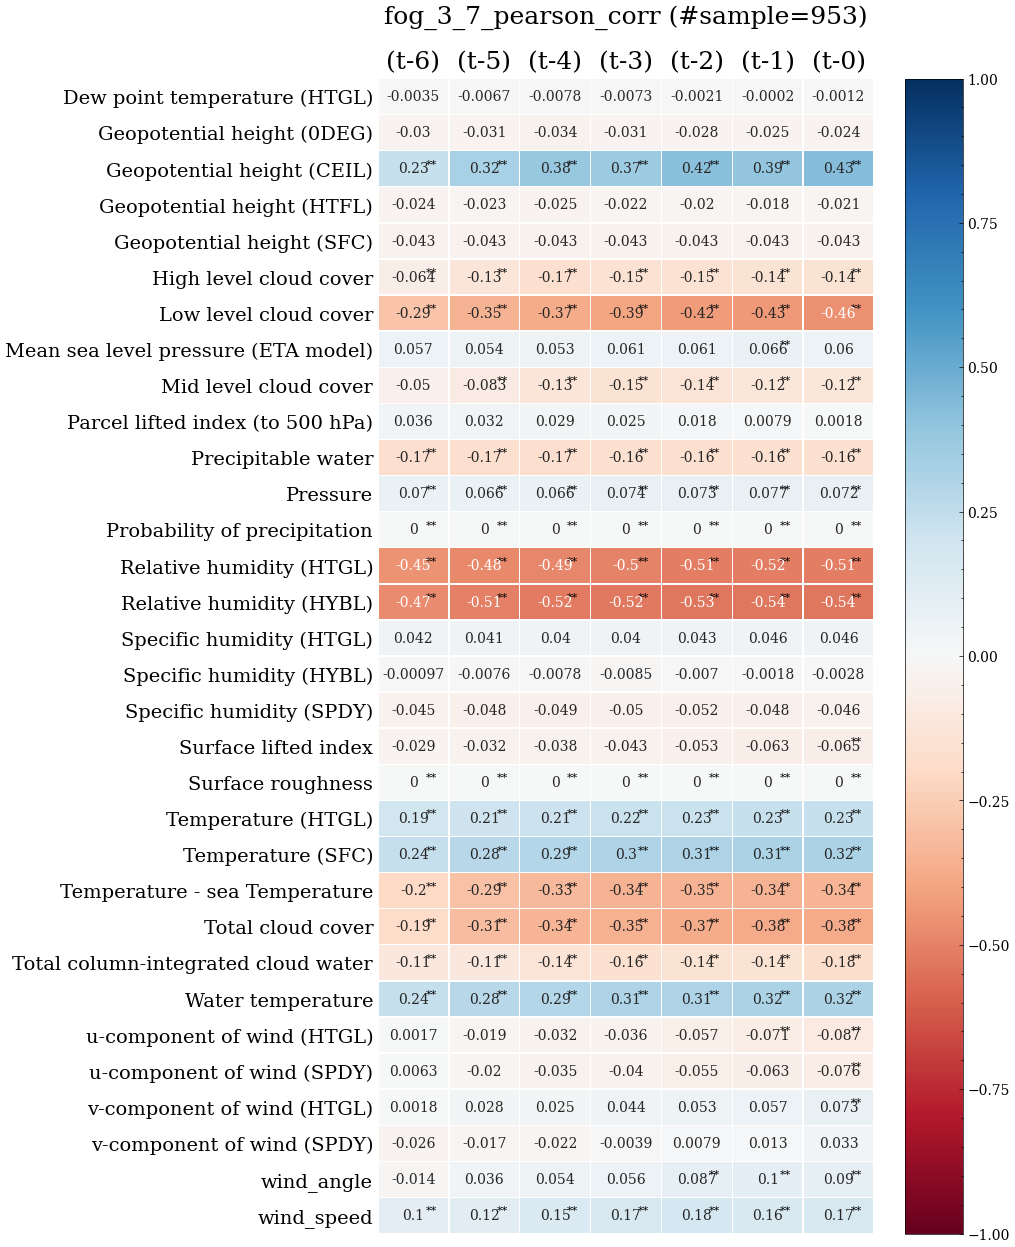

In [36]:
vis_vars = 'visibility (t6)'
wrf_vars_cols = [f'{v} (t{t})' for v in SINGLE_LEV_VARS if v!='VIS_GDS3_SFC' for t in range(time_lag+1)]
wrf_vars_cols += [f'TEMP_WTEMP (t{t})' for t in range(time_lag+1)]
wrf_vars_cols += [f'wind_speed (t{t})' for t in range(time_lag+1)]
wrf_vars_cols += [f'wind_angle (t{t})' for t in range(time_lag+1)]

# pearson correlation
corr = sample_tt[[vis_vars] + wrf_vars_cols].corr()

# significance test
sig = significance_test(sample_tt, wrf_vars_cols, vis_vars, sig_thres=0.05)

vis_sig = sig['visibility (t6)']
vis_sig = pd.DataFrame({'variables': vis_sig.index, 'sig':vis_sig.values})

vis_corr = corr['visibility (t6)'].sort_values(ascending=False)
vis_corr = pd.DataFrame({'variables': vis_corr.index, 'r':vis_corr.values})

# merge
vis_corr = vis_corr.merge(vis_sig, on='variables', how='outer')

vis_corr.to_csv(os.path.join(TLCA_results_dir, 'fog_3_7_pearson_corr.csv'))
# vis_corr

title = f'fog_3_7_pearson_corr (#sample={len(sample_tt)})'
save_prefix = os.path.join(TLCA_results_dir, 'fog_3_7_pearson_corr')
max_val = np.nanmax(vis_corr.iloc[1:]['r'].values)
min_val = np.nanmin(vis_corr.iloc[1:]['r'].values)
print(f'max_val: {max_val}, min_val: {min_val}')

draw_heatmap(vis_corr.iloc[1:], title, save_prefix, vmin=-1, vmax=1)


## Geopotential height, CEIL (HGT_GDS3_CEIL)

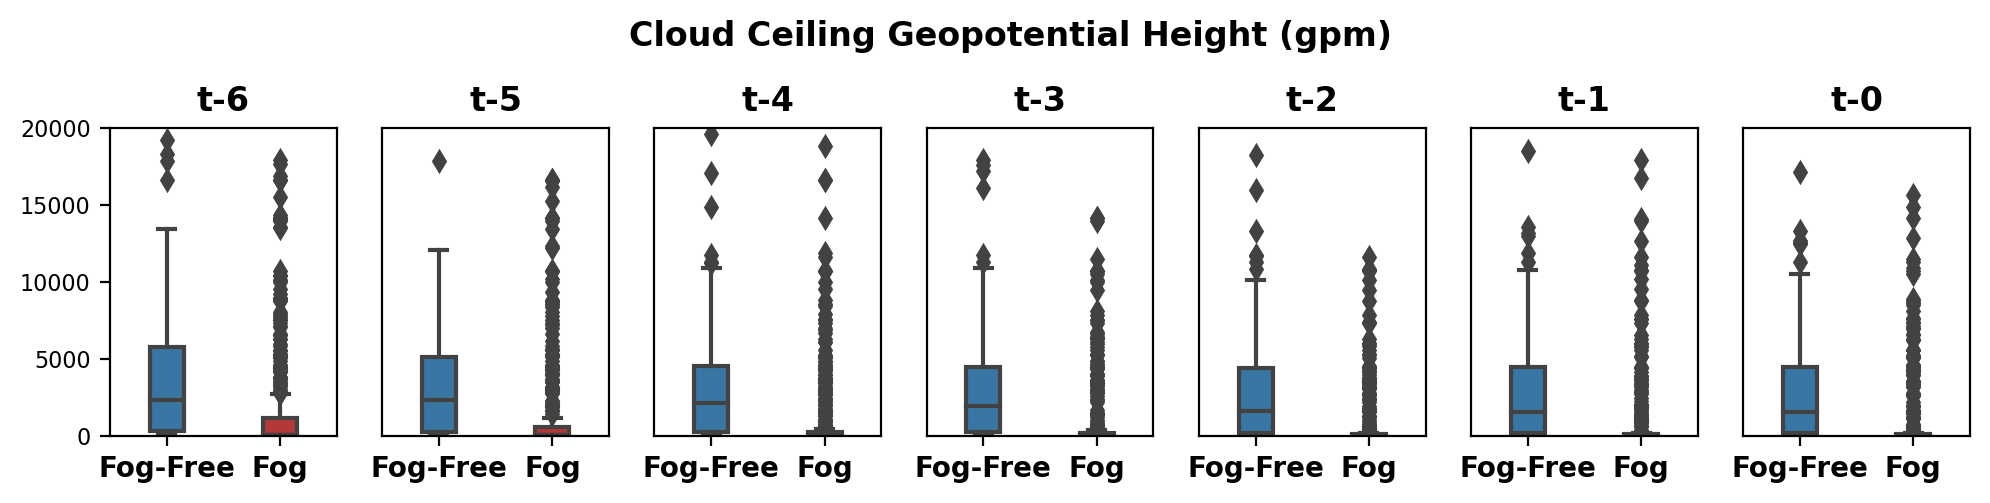

In [10]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

sample_tt = sample_tt[sample_tt['HGT_GDS3_CEIL (t0)'] <= 19999]
sample_tt = sample_tt[sample_tt['HGT_GDS3_CEIL (t1)'] <= 19999]
sample_tt = sample_tt[sample_tt['HGT_GDS3_CEIL (t2)'] <= 19999]
sample_tt = sample_tt[sample_tt['HGT_GDS3_CEIL (t3)'] <= 19999]
sample_tt = sample_tt[sample_tt['HGT_GDS3_CEIL (t4)'] <= 19999]
sample_tt = sample_tt[sample_tt['HGT_GDS3_CEIL (t5)'] <= 19999]
sample_tt = sample_tt[sample_tt['HGT_GDS3_CEIL (t6)'] <= 19999]

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

var_name = 'HGT_GDS3_CEIL'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 20000)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Cloud Ceiling Geopotential Height (gpm)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Low level cloud cover (L_CDC_GDS3_LCY)

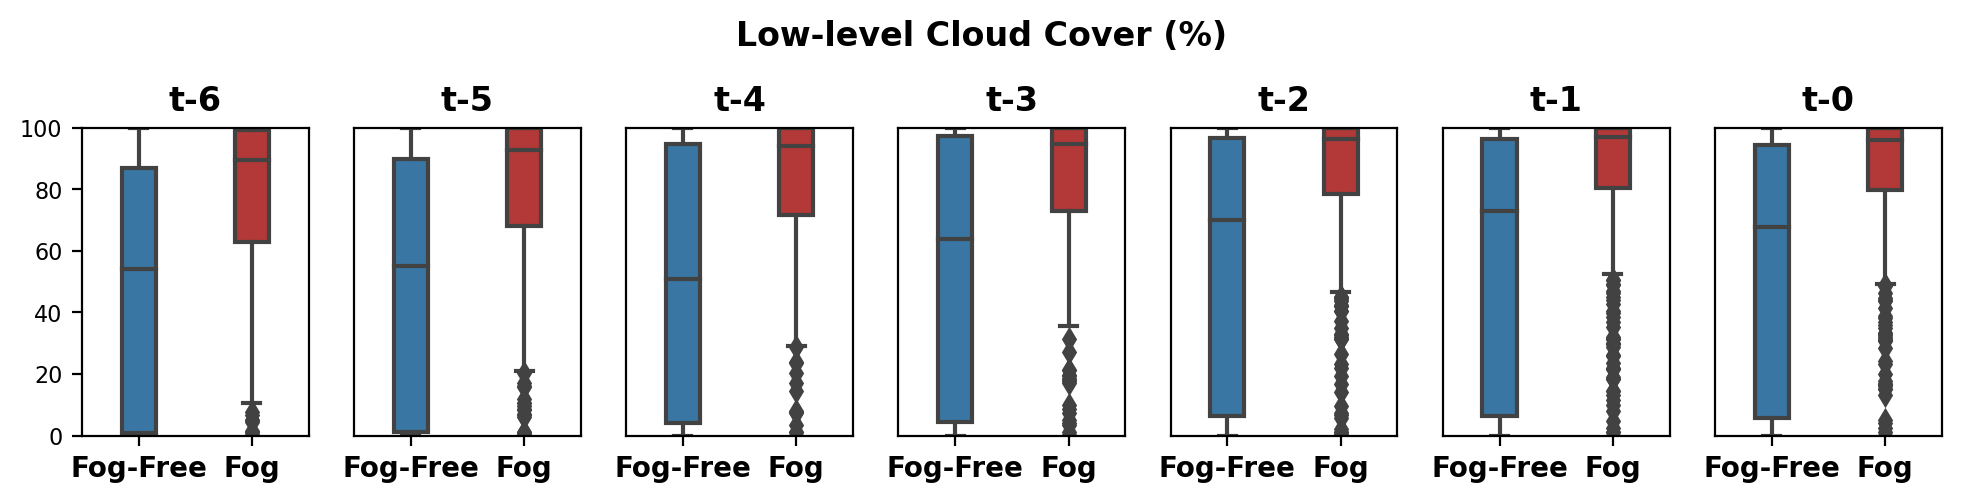

In [12]:
plt.rcdefaults()

sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

var_name = 'L_CDC_GDS3_LCY'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 100)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Low-level Cloud Cover (%)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Relative humidity, HTGL (R_H_GDS3_HTGL)

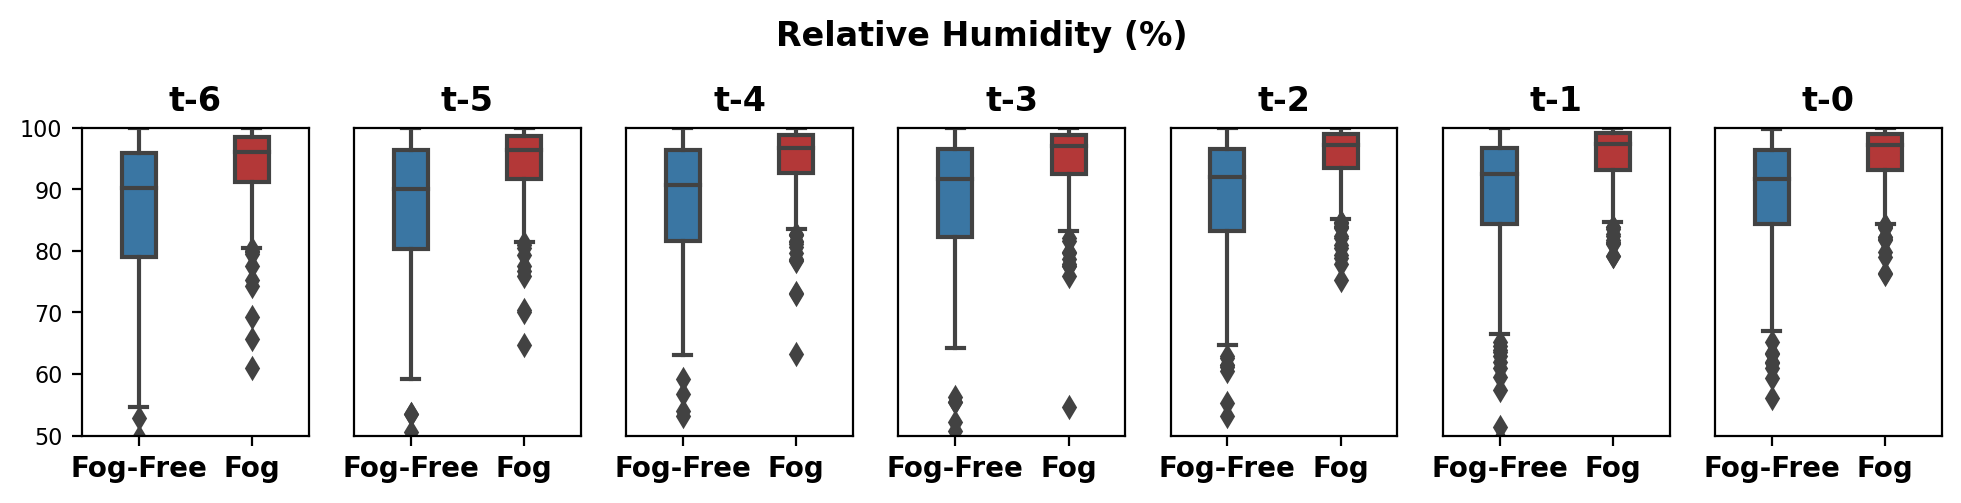

In [13]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

var_name = 'R_H_GDS3_HTGL'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(50, 100)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Relative Humidity (%)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Total cloud cover (T_CDC_GDS3_EATM)

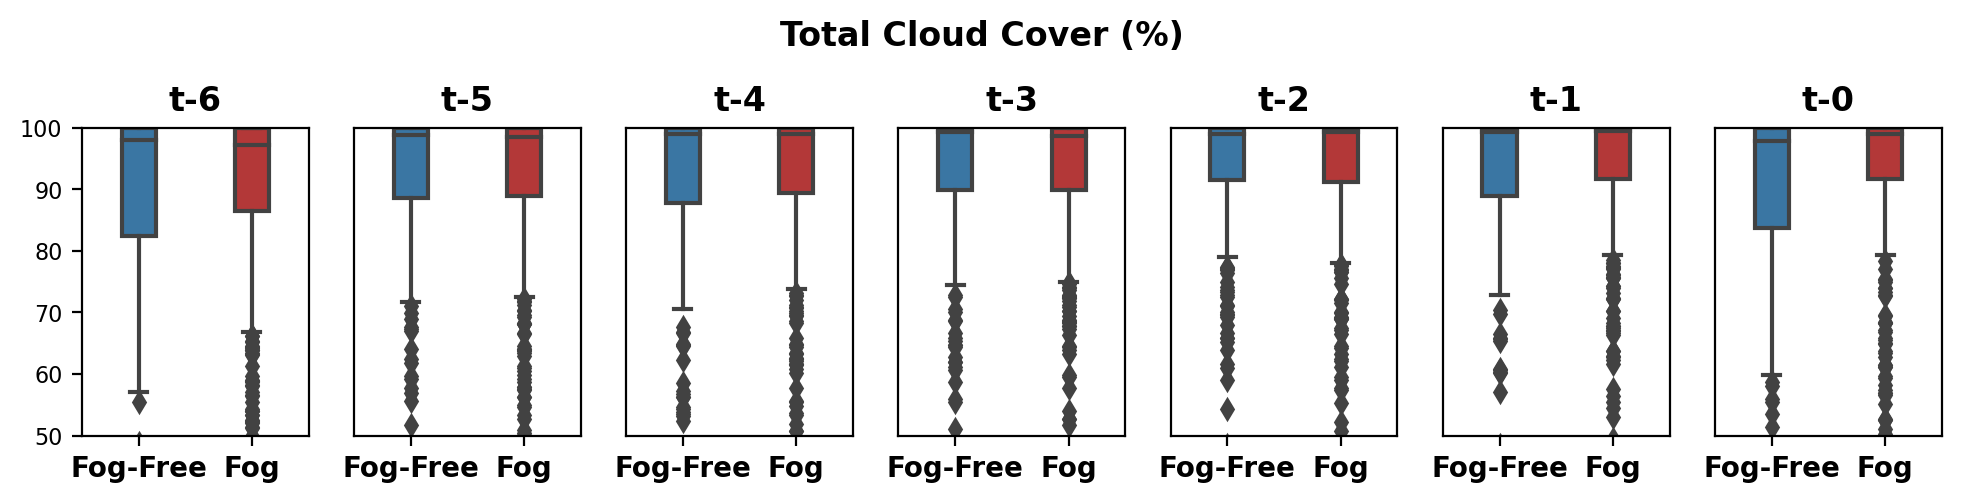

In [14]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

var_name = 'T_CDC_GDS3_EATM'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(50, 100)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Total Cloud Cover (%)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Temperature, HTGL (TMP_GDS3_HTGL)

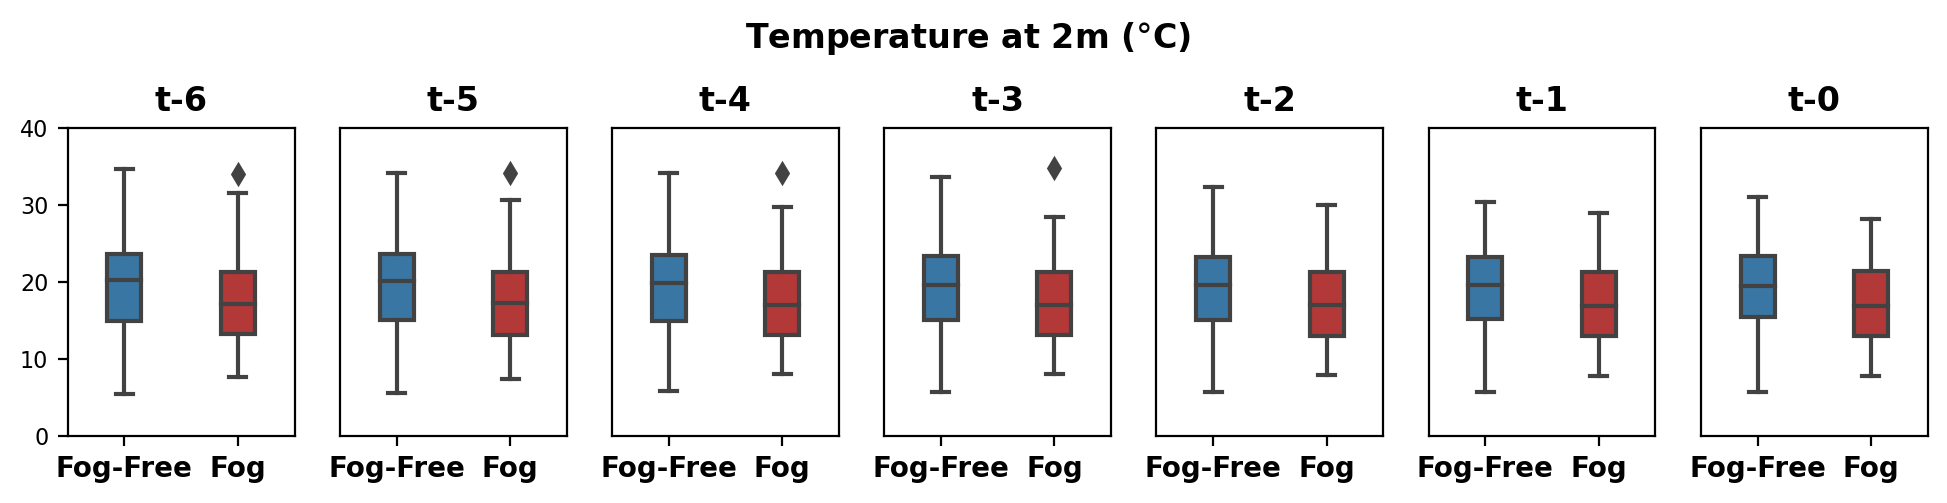

In [17]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

sample_tt['TMP_GDS3_HTGL (t0)'] = sample_tt['TMP_GDS3_HTGL (t0)'] - 273.15
sample_tt['TMP_GDS3_HTGL (t1)'] = sample_tt['TMP_GDS3_HTGL (t1)'] - 273.15
sample_tt['TMP_GDS3_HTGL (t2)'] = sample_tt['TMP_GDS3_HTGL (t2)'] - 273.15
sample_tt['TMP_GDS3_HTGL (t3)'] = sample_tt['TMP_GDS3_HTGL (t3)'] - 273.15
sample_tt['TMP_GDS3_HTGL (t4)'] = sample_tt['TMP_GDS3_HTGL (t4)'] - 273.15
sample_tt['TMP_GDS3_HTGL (t5)'] = sample_tt['TMP_GDS3_HTGL (t5)'] - 273.15
sample_tt['TMP_GDS3_HTGL (t6)'] = sample_tt['TMP_GDS3_HTGL (t6)'] - 273.15

var_name = 'TMP_GDS3_HTGL'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 40)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Temperature at 2m ($\degree$C)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Temperature, SFC (TMP_GDS3_SFC)

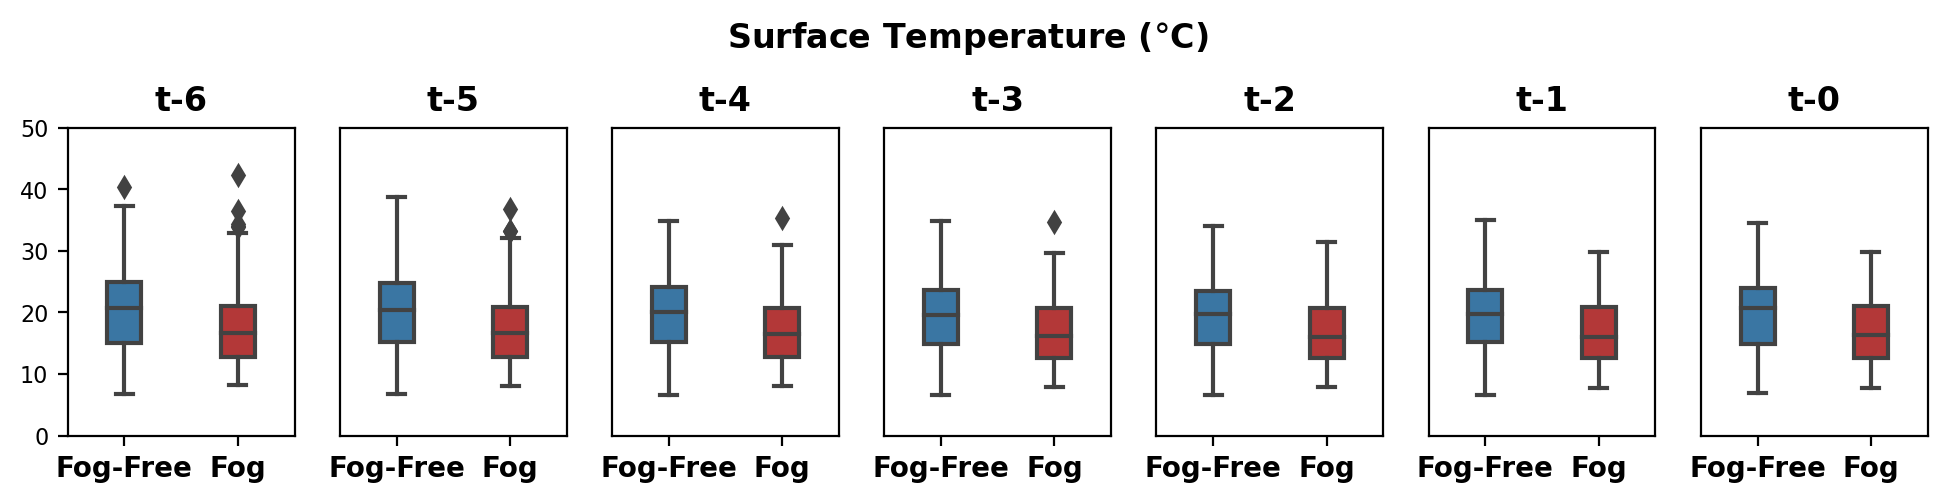

In [19]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

sample_tt['TMP_GDS3_SFC (t0)'] = sample_tt['TMP_GDS3_SFC (t0)'] - 273.15
sample_tt['TMP_GDS3_SFC (t1)'] = sample_tt['TMP_GDS3_SFC (t1)'] - 273.15
sample_tt['TMP_GDS3_SFC (t2)'] = sample_tt['TMP_GDS3_SFC (t2)'] - 273.15
sample_tt['TMP_GDS3_SFC (t3)'] = sample_tt['TMP_GDS3_SFC (t3)'] - 273.15
sample_tt['TMP_GDS3_SFC (t4)'] = sample_tt['TMP_GDS3_SFC (t4)'] - 273.15
sample_tt['TMP_GDS3_SFC (t5)'] = sample_tt['TMP_GDS3_SFC (t5)'] - 273.15
sample_tt['TMP_GDS3_SFC (t6)'] = sample_tt['TMP_GDS3_SFC (t6)'] - 273.15

var_name = 'TMP_GDS3_SFC'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 50)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Surface Temperature ($\degree$C)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Water surface temperature (WTMP_GDS3_SFC)

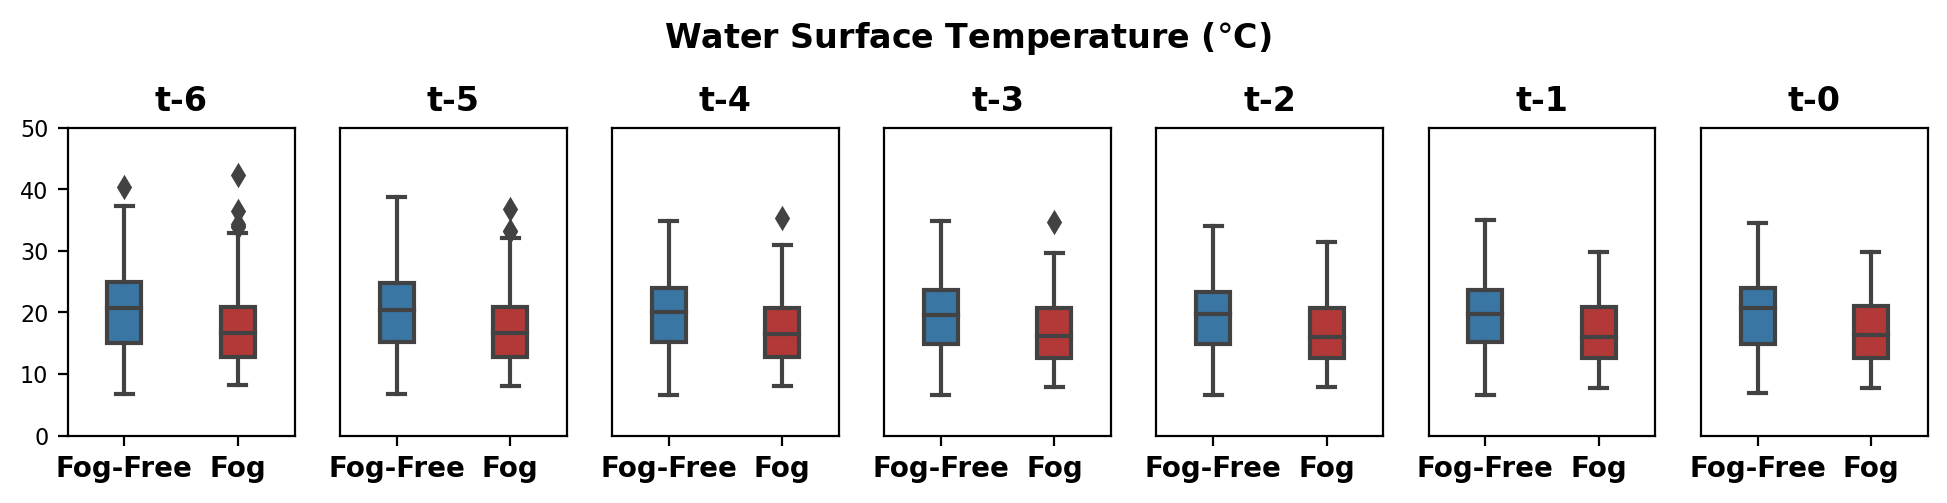

In [20]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

sample_tt['WTMP_GDS3_SFC (t0)'] = sample_tt['WTMP_GDS3_SFC (t0)'] - 273.15
sample_tt['WTMP_GDS3_SFC (t1)'] = sample_tt['WTMP_GDS3_SFC (t1)'] - 273.15
sample_tt['WTMP_GDS3_SFC (t2)'] = sample_tt['WTMP_GDS3_SFC (t2)'] - 273.15
sample_tt['WTMP_GDS3_SFC (t3)'] = sample_tt['WTMP_GDS3_SFC (t3)'] - 273.15
sample_tt['WTMP_GDS3_SFC (t4)'] = sample_tt['WTMP_GDS3_SFC (t4)'] - 273.15
sample_tt['WTMP_GDS3_SFC (t5)'] = sample_tt['WTMP_GDS3_SFC (t5)'] - 273.15
sample_tt['WTMP_GDS3_SFC (t6)'] = sample_tt['WTMP_GDS3_SFC (t6)'] - 273.15

var_name = 'WTMP_GDS3_SFC'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 50)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Water Surface Temperature ($\degree$C)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Precipitable water (P_WAT_GDS3_EATM)

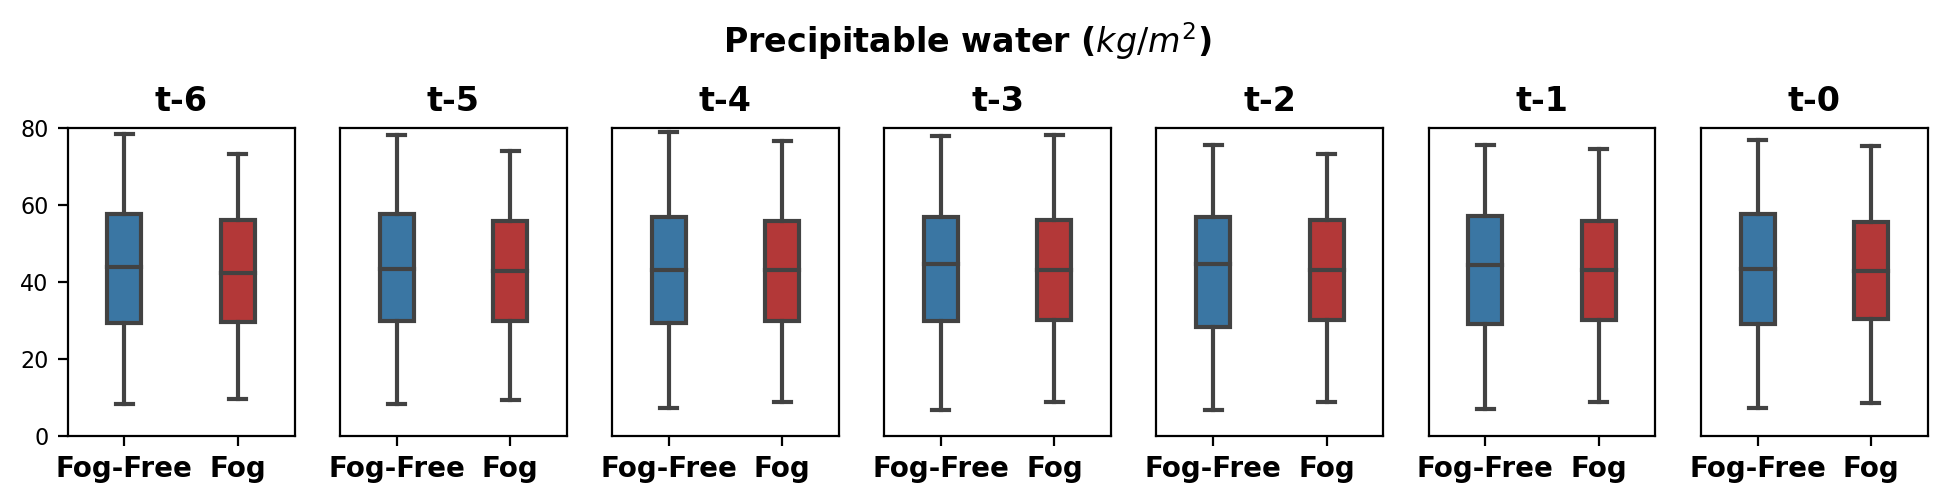

In [22]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

var_name = 'P_WAT_GDS3_EATM'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 80)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Precipitable water ($kg/m^2$)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Temperature difference between air and surface (water)

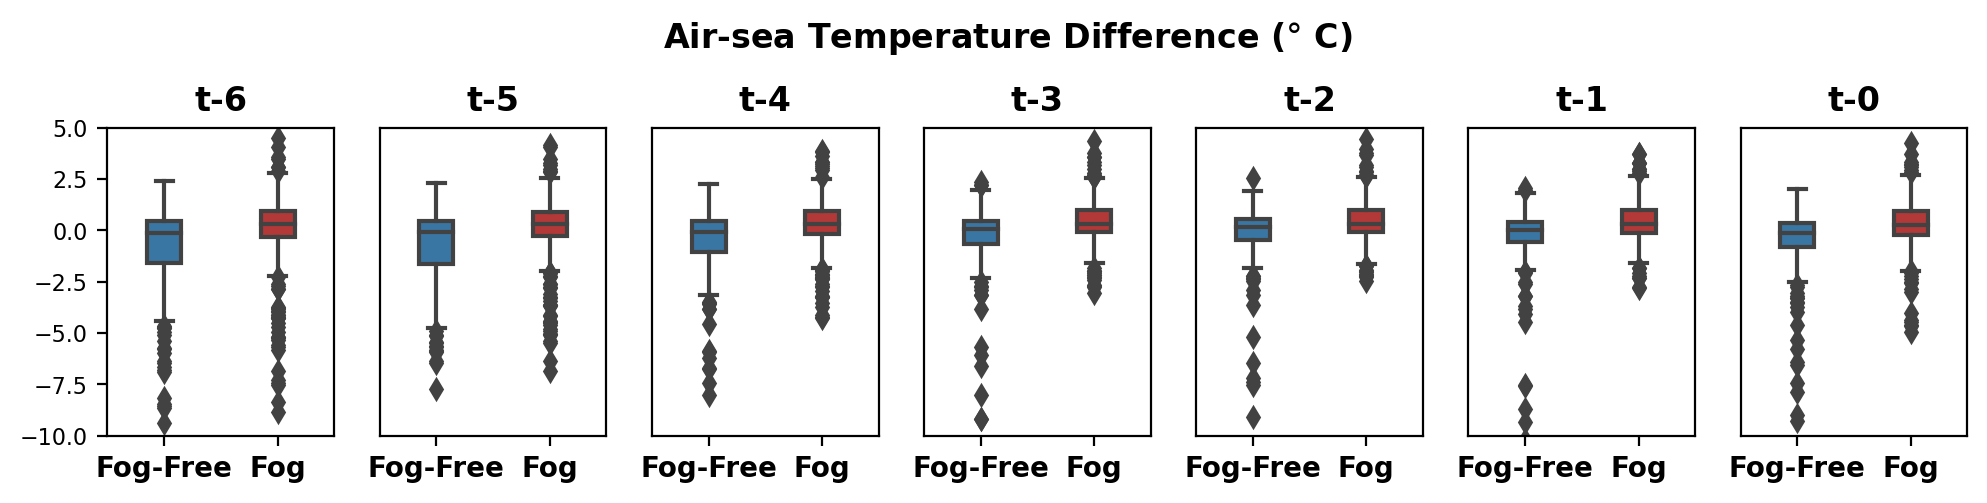

In [24]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

var_name = 'TEMP_WTEMP'
width=0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(-10, 5)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Air-sea Temperature Difference ($\degree$ C)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()

## Wind speed

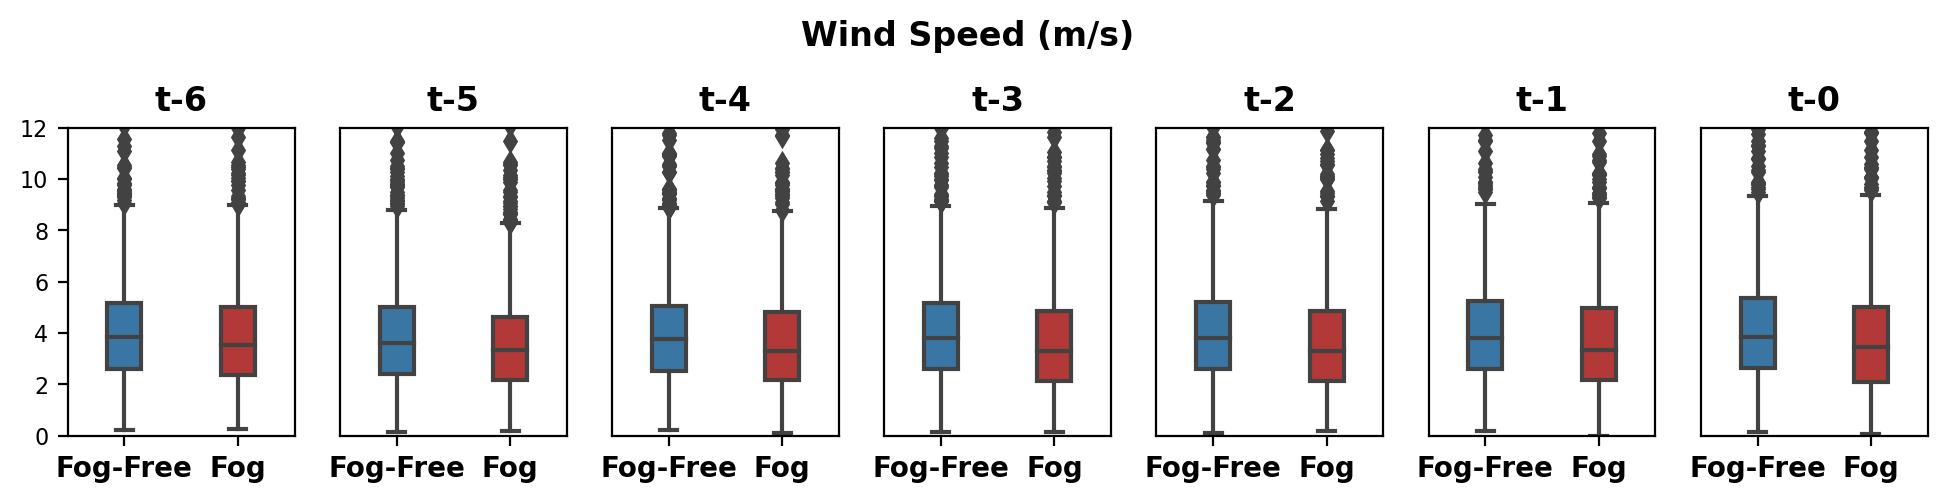

In [29]:
sample_tt['fog_cls'] = np.where((sample_tt['visibility (t6)']<=1) & 
                                (sample_tt['current_weather (t6)']>=40) & 
                                (sample_tt['current_weather (t6)']<=49), 1, 0) 

plt.rcdefaults()

colors = ["#2878B5", "#C82423"]

f, axes = plt.subplots(nrows=1, ncols=7, figsize=(12,2), dpi=200)

var_name = 'wind_speed'
width = 0.3

sns.boxplot(x='fog_cls', y=f"{var_name} (t0)", width=width, data=sample_tt, palette=colors, ax=axes[0])

sns.boxplot(x='fog_cls', y=f"{var_name} (t1)", width=width, data=sample_tt, palette=colors, ax=axes[1])

sns.boxplot(x='fog_cls', y=f"{var_name} (t2)", width=width, data=sample_tt, palette=colors, ax=axes[2])

sns.boxplot(x='fog_cls', y=f"{var_name} (t3)", width=width, data=sample_tt, palette=colors, ax=axes[3])

sns.boxplot(x='fog_cls', y=f"{var_name} (t4)", width=width, data=sample_tt, palette=colors, ax=axes[4])

sns.boxplot(x='fog_cls', y=f"{var_name} (t5)", width=width, data=sample_tt, palette=colors, ax=axes[5])

sns.boxplot(x='fog_cls', y=f"{var_name} (t6)", width=width, data=sample_tt, palette=colors, ax=axes[6])

for i,ax in enumerate(axes.ravel()):
    ax.set_title(f't-{6-i}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0, 12)
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_xticklabels(['Fog-Free', 'Fog'], fontweight='bold')

axes[0].tick_params(axis='y', which='both', left=True, labelleft=True)

f.suptitle('Wind Speed (m/s)', y=1.15, fontsize=12, fontweight='bold')

plt.show()
plt.close()